#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"




Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [ ]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Ejemplo de salida de una imágen luego de aplicada la transformación Canny

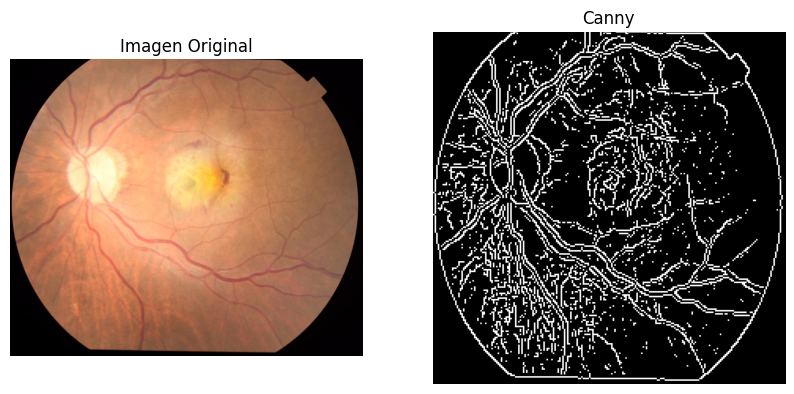

In [ ]:
image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

# Comprobar y convertir el tipo de la imagen a uint8 si es necesario

image1 = cv2.resize(image, (224,224))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image1 = cv2.Canny(image1, 40, 40)

# Mostrar la imagen original y la imagen con Canny
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Canny')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

## Visualizamos algunas de las imagenes del dataset

In [ ]:
def show_6_images(vector_imagenes, filtro, titulo):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
      img = cv2.imread(vector_imagenes[i])
      img = cv2.resize(img, (220,220))
      if (filtro =="Canny"):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.Canny(img, 80, 100)
      ax.imshow(img)
      ax.set_title(titulo)
  fig.tight_layout()
  plt.show()

Función para convertir la imágen aplicando el filtro Canny.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocessing_image(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if gray_image.dtype != np.uint8:
        gray_image = (255 * (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))).astype(np.uint8)

    # Aplicar el filtro Canny
    edges = cv2.Canny(gray_image, 40, 40)

    # Convertir la imagen de bordes a BGR (3 canales)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Redimensionar la imagen al tamaño esperado por el modelo
    edges_resized = cv2.resize(edges_colored, (224, 224))

    # Preprocesar la imagen para ResNet50V2
    edges_preprocessed = preprocess_input(edges_resized)

    return edges_preprocessed



## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224,3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1


In [ ]:
base_model1a = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model1a.layers:
    layer.trainable = False


model1a = Sequential()
model1a.add(base_model1a)
model1a.add(GlobalAveragePooling2D())
model1a.add(Dense(128, activation = 'relu'))
model1a.add(Dropout(0.2))
model1a.add(Dense(6, activation='softmax'))
model1a.summary()

model1a.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1a = model1a.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 128)               245888    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 774       
                                                                 
Total params: 18568646 (70.83 MB)
Trainable params: 246662 (963.52 KB)
Non-trainable params: 18321984 (69.89 MB)
_______

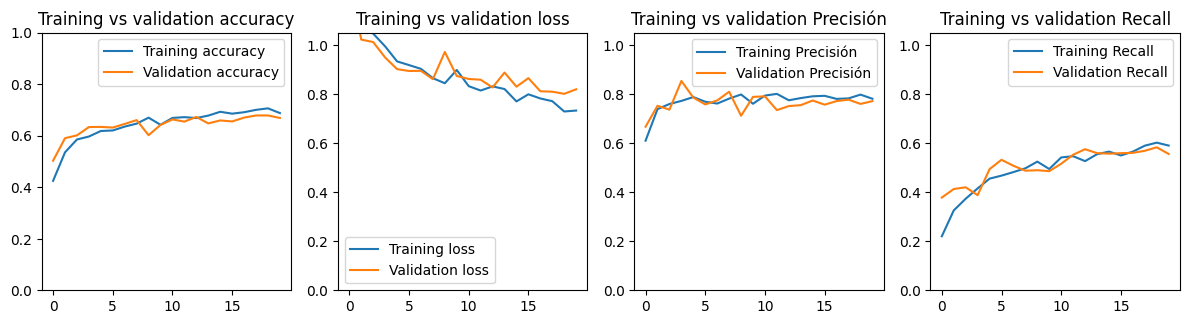

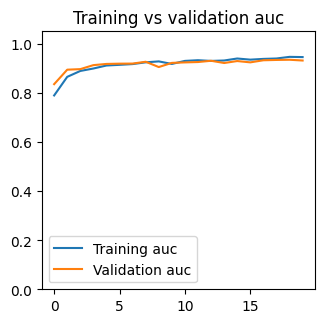

In [ ]:
graph(history1a)

In [ ]:
y_pred1a_test = model1a.predict(test_generator)
y_pred1a_val = model1a.predict(validation_generator)

39/39 [==============================] - 13s 336ms/step


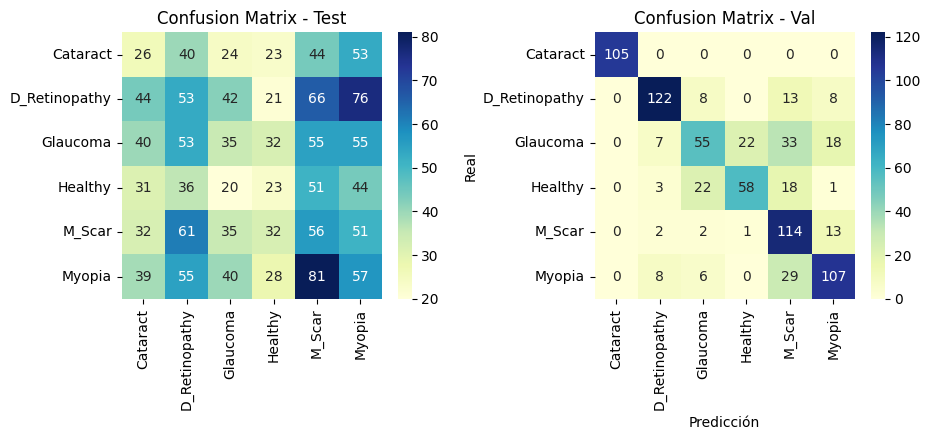

In [ ]:
cf_matrix(y_pred1a_test, test_generator.classes, y_pred1a_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1a, y_pred1a_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1a, y_pred1a_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.18      0.18      0.18       302
           2       0.18      0.13      0.15       270
           3       0.14      0.11      0.13       205
           4       0.16      0.21      0.18       267
           5       0.17      0.19      0.18       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.86      0.81      0.83       151
           2       0.59      0.41      0.48       135
           3       0.72      0.57      0.63       102
           4       0.55      0.86      0.67       132
           5       0.73      0.71      0.72       150

    accuracy                           0.72       775
   macro avg       0.74

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18847430 (71.90 MB)
Trainable params: 52544

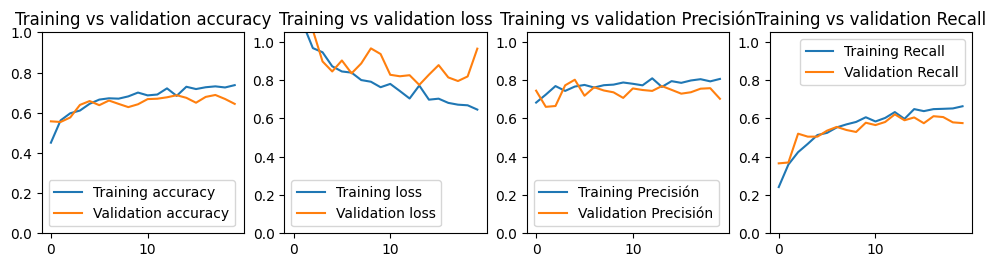

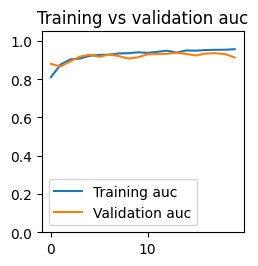

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 19s 488ms/step


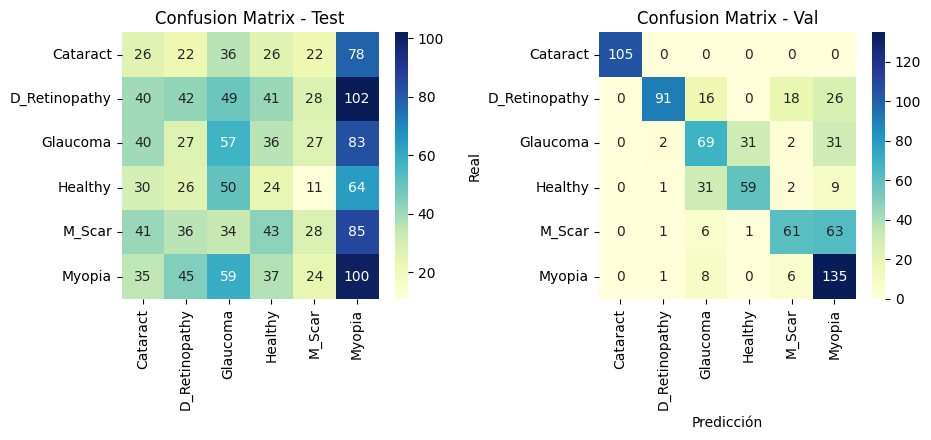

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.21      0.14      0.17       302
           2       0.20      0.21      0.21       270
           3       0.12      0.12      0.12       205
           4       0.20      0.10      0.14       267
           5       0.20      0.33      0.25       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.95      0.60      0.74       151
           2       0.53      0.51      0.52       135
           3       0.65      0.58      0.61       102
           4       0.69      0.46      0.55       132
           5       0.51      0.90      0.65       150

    accuracy                           0.67       775
   macro avg       0.72

## Modelo 5

In [ ]:
base_model5 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model5.layers:
    layer.trainable = False


model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2056)              3949576   
                                                                 
 dense_4 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

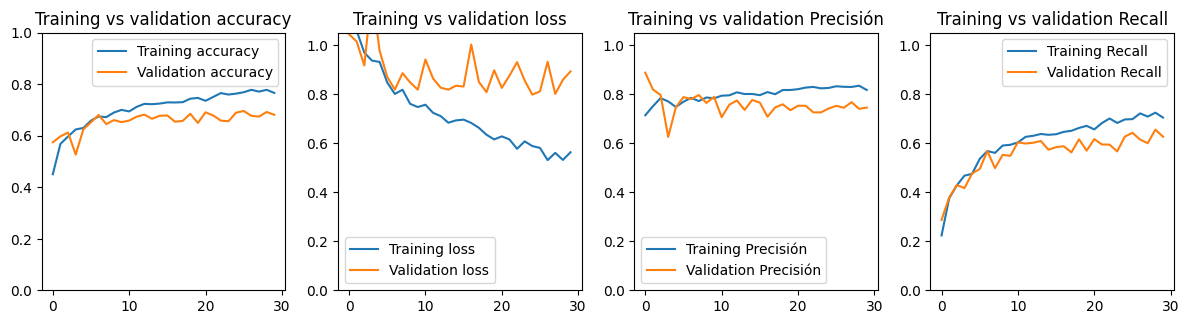

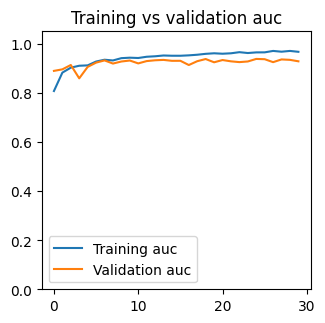

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 13s 345ms/step


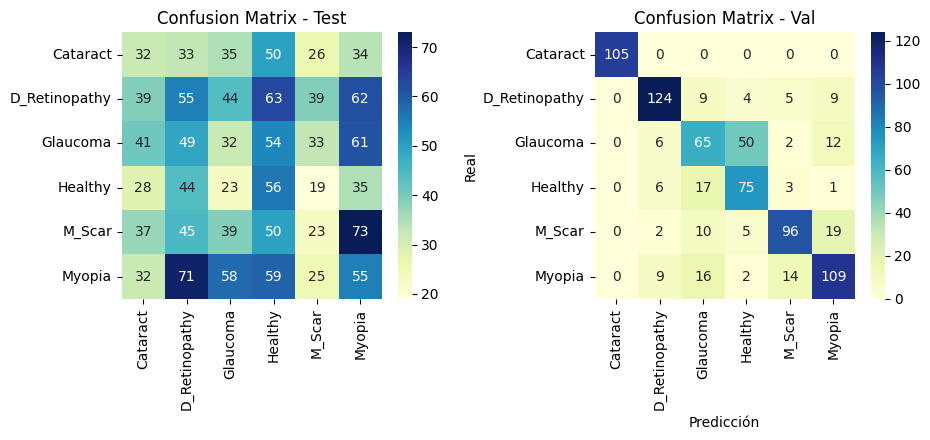

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.19      0.18      0.18       302
           2       0.14      0.12      0.13       270
           3       0.17      0.27      0.21       205
           4       0.14      0.09      0.11       267
           5       0.17      0.18      0.18       300

    accuracy                           0.16      1554
   macro avg       0.16      0.17      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.84      0.82      0.83       151
           2       0.56      0.48      0.52       135
           3       0.55      0.74      0.63       102
           4       0.80      0.73      0.76       132
           5       0.73      0.73      0.73       150

    accuracy                           0.74       775
   macro avg       0.75

## Modelo 15

In [ ]:
base_model15 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model15.layers:
    layer.trainable = False


model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 2056)              3949576   
                                                                 
 dense_9 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                      

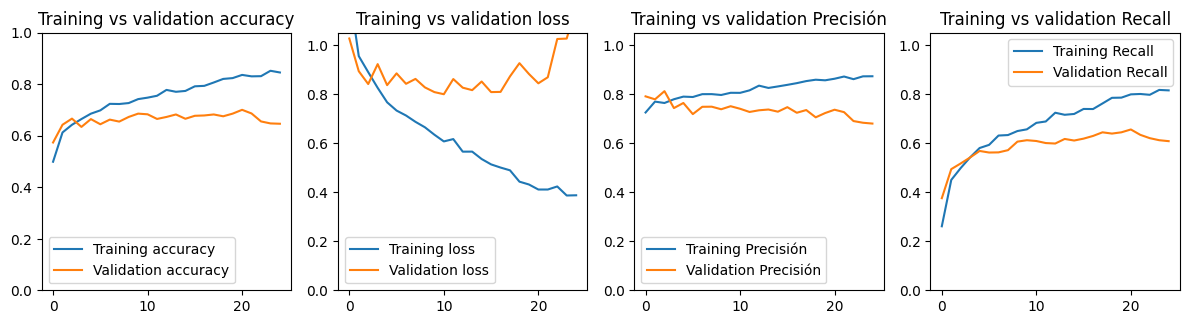

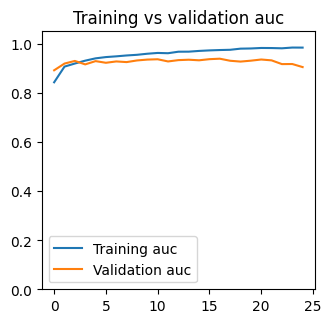

In [ ]:
graph(history15)

39/39 [==============================] - 13s 343ms/step


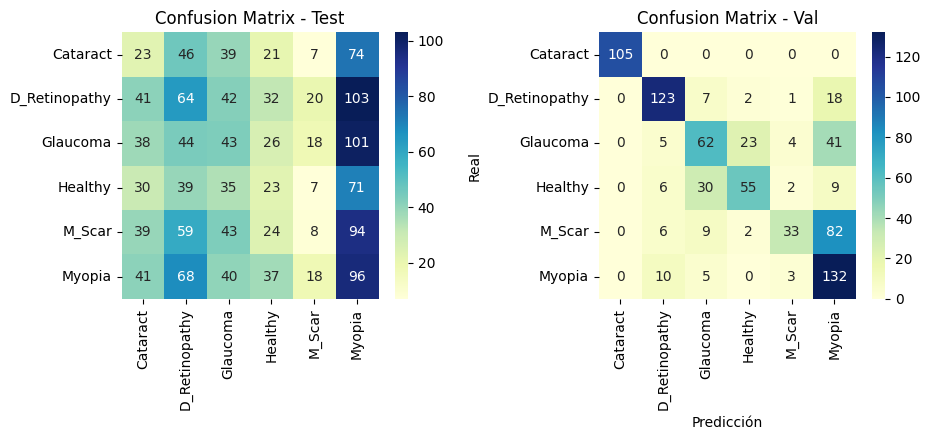

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.11      0.11       210
           1       0.20      0.21      0.21       302
           2       0.18      0.16      0.17       270
           3       0.14      0.11      0.12       205
           4       0.10      0.03      0.05       267
           5       0.18      0.32      0.23       300

    accuracy                           0.17      1554
   macro avg       0.15      0.16      0.15      1554
weighted avg       0.16      0.17      0.15      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.82      0.81      0.82       151
           2       0.55      0.46      0.50       135
           3       0.67      0.54      0.60       102
           4       0.77      0.25      0.38       132
           5       0.47      0.88      0.61       150

    accuracy                           0.66       775
   macro avg       0.71

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 2056)              3949576   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                      

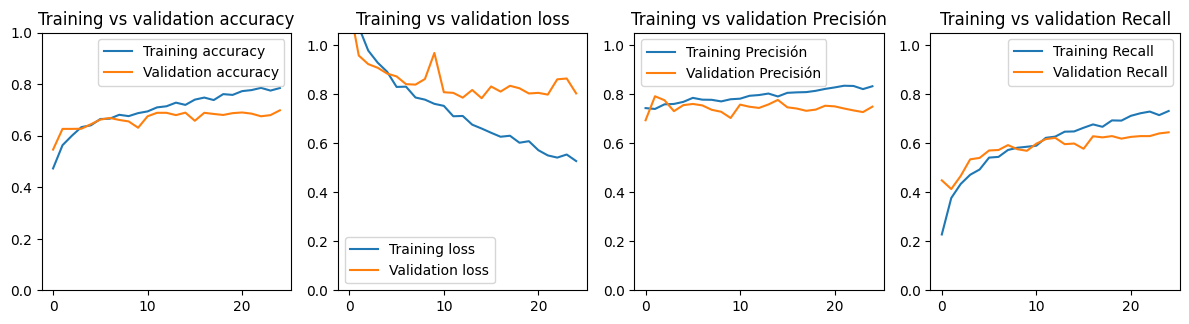

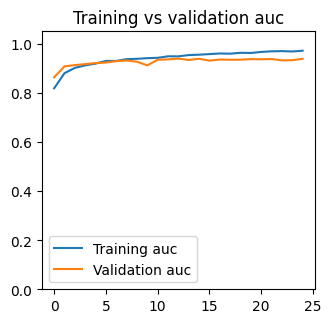

In [ ]:
graph(history16)

39/39 [==============================] - 14s 362ms/step


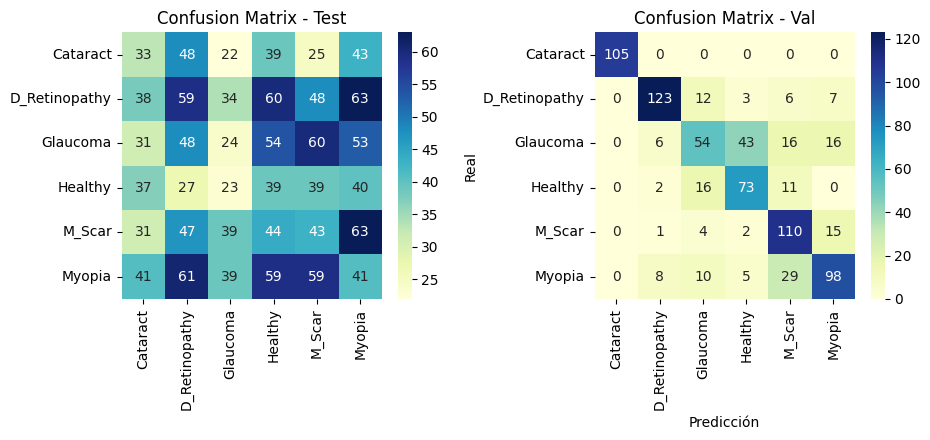

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.20      0.20      0.20       302
           2       0.13      0.09      0.11       270
           3       0.13      0.19      0.16       205
           4       0.16      0.16      0.16       267
           5       0.14      0.14      0.14       300

    accuracy                           0.15      1554
   macro avg       0.15      0.15      0.15      1554
weighted avg       0.15      0.15      0.15      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.88      0.81      0.85       151
           2       0.56      0.40      0.47       135
           3       0.58      0.72      0.64       102
           4       0.64      0.83      0.72       132
           5       0.72      0.65      0.69       150

    accuracy                           0.73       775
   macro avg       0.73

## Modelo 6

In [ ]:
base_model6 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_4  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 5112)              9820152   
                                                                 
 dense_19 (Dense)            (None, 2056)              10512328  
                                                                 
 dense_20 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                      

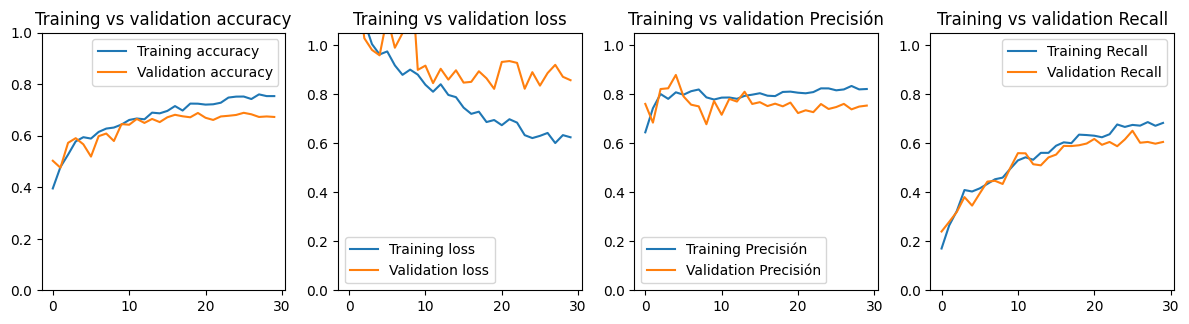

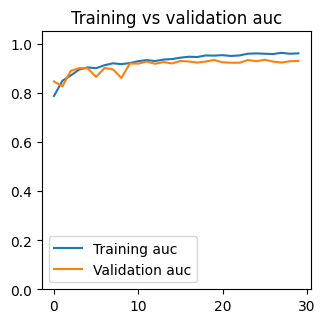

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 13s 345ms/step


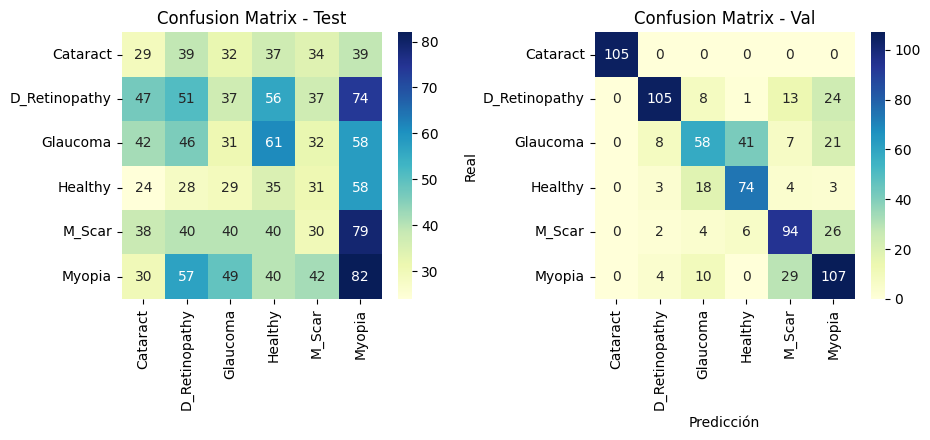

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.20      0.17      0.18       302
           2       0.14      0.11      0.13       270
           3       0.13      0.17      0.15       205
           4       0.15      0.11      0.13       267
           5       0.21      0.27      0.24       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.86      0.70      0.77       151
           2       0.59      0.43      0.50       135
           3       0.61      0.73      0.66       102
           4       0.64      0.71      0.67       132
           5       0.59      0.71      0.65       150

    accuracy                           0.70       775
   macro avg       0.71

## Modelo 20

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model20a = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model20a.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model20a.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model20a = Model(inputs=base_model20a.input, outputs=predictions)

# Compilar el modelo
model20a.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
# Imprimir un resumen del modelo
model20a.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20a.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

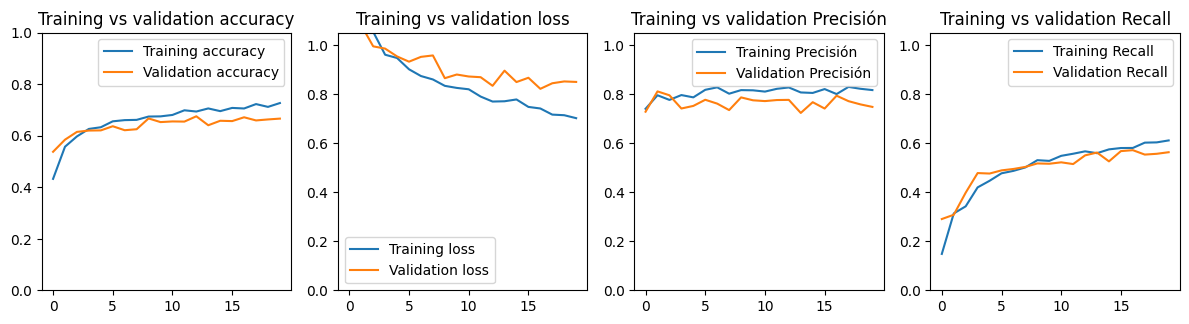

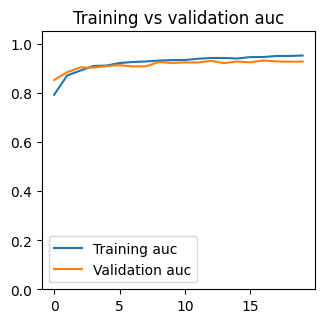

In [ ]:
graph(history_dense)

39/39 [==============================] - 17s 431ms/step


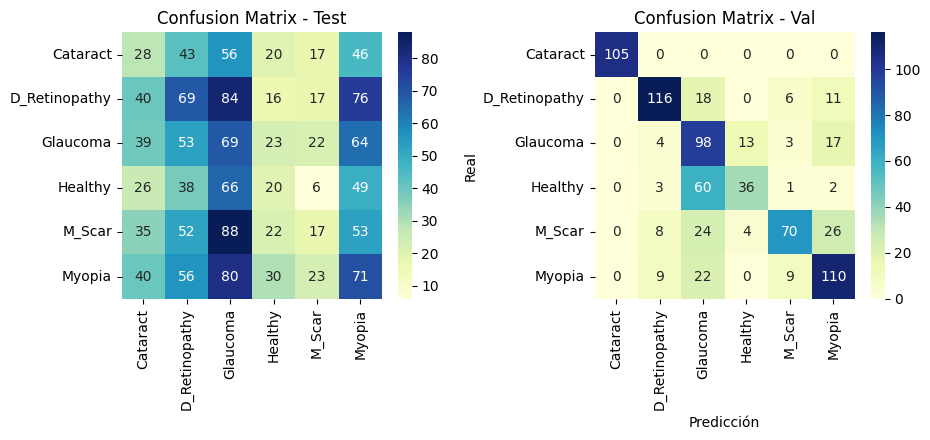

In [ ]:
y_pred_test = model20a.predict(test_generator)
y_pred_val = model20a.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model20a, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model20a, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.22      0.23      0.23       302
           2       0.16      0.26      0.19       270
           3       0.15      0.10      0.12       205
           4       0.17      0.06      0.09       267
           5       0.20      0.24      0.22       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.83      0.77      0.80       151
           2       0.44      0.73      0.55       135
           3       0.68      0.35      0.46       102
           4       0.79      0.53      0.63       132
           5       0.66      0.73      0.70       150

    accuracy                           0.69       775
   macro avg       0.73

## Modelo 19

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 97s 558ms/step - loss: 1.5443 - accuracy: 0.3429 - precision: 0.7023 - recall: 0.0899 - auc: 0.7218 - val_loss: 1.3132 - val_accuracy: 0.3951 - val_precision: 0.7591 - val_recall: 0.1885 - val_auc: 0.8115
Epoch 2/25
150/150 [==============================] - 79s 528ms/step - loss: 1.3163 - accuracy: 0.4490 - precision: 0.7162 - recall: 0.2010 - auc: 0.8095 - val_loss: 1.2202 - val_accuracy: 0.4743 - val_precision: 0.6312 - val_recall: 0.3127 - val_auc: 0.8408
Epoch 3/25
150/150 [==============================] - 79s 528ms/step - loss: 1.2278 - accuracy: 0.4779 - precision: 0.7063 - recall: 0.2564 - auc: 0.8383 - val_loss: 1.0771 - val_accuracy: 0.5676 - val_precision: 0.8090 - val_recall: 0.3243 - val_auc: 0.8797
Epoch 4/25
150/150 [==============================] - 78s 522ms/step - loss: 1.1299 - accuracy: 0.5294 - precision: 0.7471 - recall: 0.3209 - auc: 0.8648 - val_loss: 1.0235 - val_accuracy: 0.5785 - val_precision: 0.7932 - v

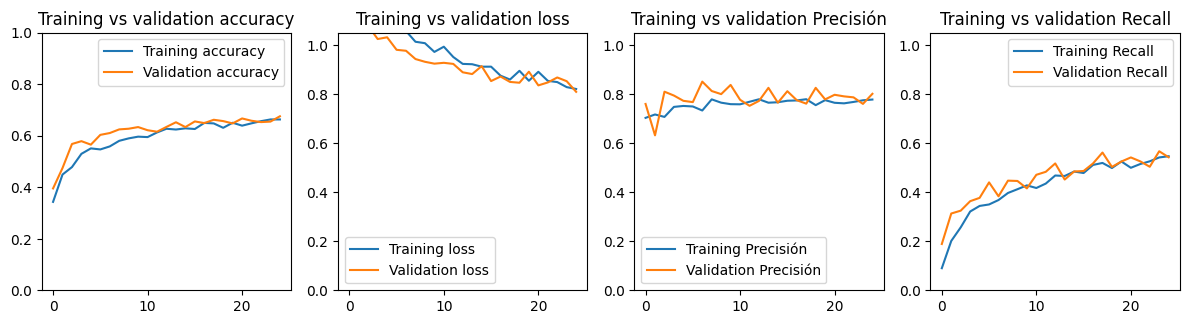

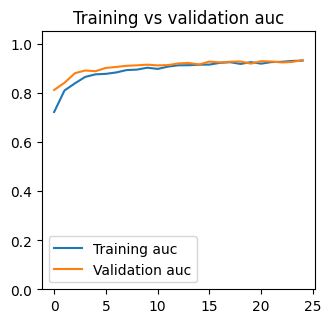

In [ ]:
graph(history19)

39/39 [==============================] - 14s 359ms/step


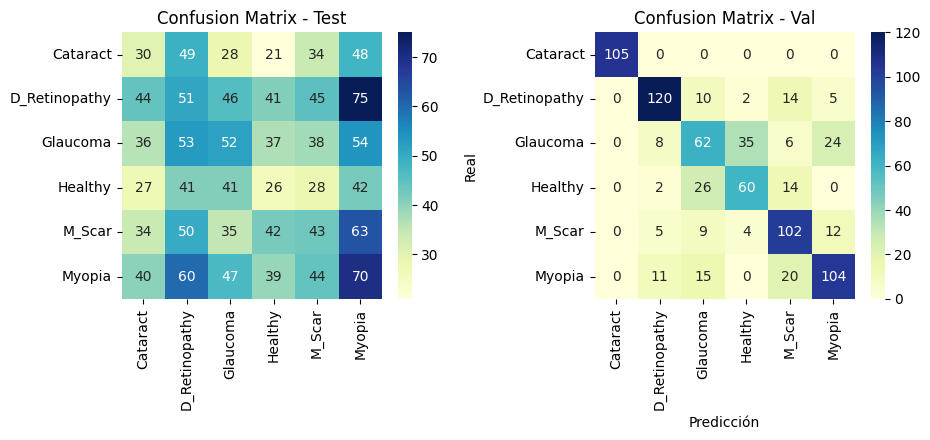

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.17      0.17      0.17       302
           2       0.21      0.19      0.20       270
           3       0.13      0.13      0.13       205
           4       0.19      0.16      0.17       267
           5       0.20      0.23      0.21       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.82      0.79      0.81       151
           2       0.51      0.46      0.48       135
           3       0.59      0.59      0.59       102
           4       0.65      0.77      0.71       132
           5       0.72      0.69      0.71       150

    accuracy                           0.71       775
   macro avg       0.72

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1a)

Evaluar con Entrenamiento:
272/272 [==============================] - 91s 334ms/step - loss: 0.6909 - accuracy: 0.7193 - precision: 0.8258 - recall: 0.6110 - auc: 0.9516
Evaluar con Validación:
78/78 [==============================] - 27s 345ms/step - loss: 0.8188 - accuracy: 0.6686 - precision: 0.7705 - recall: 0.5553 - auc: 0.9315
Evaluar con Prueba:
39/39 [==============================] - 14s 367ms/step - loss: 0.7110 - accuracy: 0.7239 - precision: 0.7929 - recall: 0.6026 - auc: 0.9484


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 91s 333ms/step - loss: 0.7500 - accuracy: 0.6994 - precision: 0.7636 - recall: 0.6309 - auc: 0.9432
Evaluar con Validación:
78/78 [==============================] - 31s 396ms/step - loss: 0.9651 - accuracy: 0.6441 - precision: 0.7031 - recall: 0.5759 - auc: 0.9137
Evaluar con Prueba:
39/39 [==============================] - 14s 348ms/step - loss: 0.8247 - accuracy: 0.6710 - precision: 0.7117 - recall: 0.6116 - auc: 0.9330


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 90s 331ms/step - loss: 0.4974 - accuracy: 0.8003 - precision: 0.8598 - recall: 0.7303 - auc: 0.9751
Evaluar con Validación:
78/78 [==============================] - 27s 342ms/step - loss: 0.8916 - accuracy: 0.6808 - precision: 0.7443 - recall: 0.6255 - auc: 0.9282
Evaluar con Prueba:
39/39 [==============================] - 13s 342ms/step - loss: 0.7531 - accuracy: 0.7406 - precision: 0.7970 - recall: 0.6890 - auc: 0.9451


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 93s 342ms/step - loss: 0.5105 - accuracy: 0.7830 - precision: 0.8198 - recall: 0.7471 - auc: 0.9730
Evaluar con Validación:
78/78 [==============================] - 26s 332ms/step - loss: 1.1575 - accuracy: 0.6461 - precision: 0.6791 - recall: 0.6075 - auc: 0.9047
Evaluar con Prueba:
39/39 [==============================] - 14s 359ms/step - loss: 1.0230 - accuracy: 0.6581 - precision: 0.6797 - recall: 0.6077 - auc: 0.9201


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 91s 334ms/step - loss: 0.4529 - accuracy: 0.8236 - precision: 0.8635 - recall: 0.7712 - auc: 0.9793
Evaluar con Validación:
78/78 [==============================] - 28s 355ms/step - loss: 0.8021 - accuracy: 0.6982 - precision: 0.7479 - recall: 0.6435 - auc: 0.9383
Evaluar con Prueba:
39/39 [==============================] - 14s 352ms/step - loss: 0.7027 - accuracy: 0.7265 - precision: 0.7786 - recall: 0.6942 - auc: 0.9520


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 89s 328ms/step - loss: 0.5885 - accuracy: 0.7660 - precision: 0.8309 - recall: 0.6846 - auc: 0.9650
Evaluar con Validación:
78/78 [==============================] - 28s 350ms/step - loss: 0.8558 - accuracy: 0.6725 - precision: 0.7524 - recall: 0.6042 - auc: 0.9298
Evaluar con Prueba:
39/39 [==============================] - 13s 348ms/step - loss: 0.7232 - accuracy: 0.7006 - precision: 0.7567 - recall: 0.6219 - auc: 0.9467


In [ ]:
evaluar_modelo(model19) ## Modelo 19 DenseNet201

Evaluar con Entrenamiento:
272/272 [==============================] - 97s 357ms/step - loss: 0.7127 - accuracy: 0.7226 - precision: 0.8459 - recall: 0.5711 - auc: 0.9504
Evaluar con Validación:
78/78 [==============================] - 27s 348ms/step - loss: 0.8084 - accuracy: 0.6750 - precision: 0.8004 - recall: 0.5418 - auc: 0.9331
Evaluar con Prueba:
39/39 [==============================] - 14s 357ms/step - loss: 0.7237 - accuracy: 0.7135 - precision: 0.8206 - recall: 0.5665 - auc: 0.9481


In [ ]:
evaluar_modelo(model20a) ## Modelo 20 DenseNet201

Evaluar con Entrenamiento:
272/272 [==============================] - 94s 346ms/step - loss: 0.7201 - accuracy: 0.7086 - precision: 0.7989 - recall: 0.6062 - auc: 0.9483
Evaluar con Validación:
78/78 [==============================] - 27s 342ms/step - loss: 0.8488 - accuracy: 0.6660 - precision: 0.7470 - recall: 0.5624 - auc: 0.9273
Evaluar con Prueba:
39/39 [==============================] - 13s 344ms/step - loss: 0.7311 - accuracy: 0.6903 - precision: 0.7739 - recall: 0.5961 - auc: 0.9460
